In [12]:
from langchain_openai import ChatOpenAI
from langchain_cohere import ChatCohere
from dotenv import load_dotenv
from os import getenv

load_dotenv()

MODEL_NAME0 = 'google/gemma-3-27b-it:free'
MODEL_NAME1 = 'meta-llama/llama-4-maverick:free'
API_KEY = getenv("OPENAI_API_KEY")

# Initialize the LLM
agent_llm = ChatOpenAI(
    api_key=API_KEY,
    base_url='https://openrouter.ai/api/v1',
    model=MODEL_NAME0,
)

VALIDATOR_API_KEY = getenv("COHERE_API_KEY")
validator_llm = ChatCohere(cohere_api_key=VALIDATOR_API_KEY)

In [13]:
agent_memory = []
sentiment_array = []

In [17]:
# simple prisoner's dilemma arena without communication
import random
from textblob import TextBlob
from typing import List, Tuple, TypedDict

from langchain.schema import SystemMessage, HumanMessage, AIMessage
from langgraph.graph import StateGraph, END

# === Define the Game State ===
class GameState(TypedDict):
    history: List[Tuple[str, str]]           # (agent1_move, agent2_move)
    scores: Tuple[int, int]                  # (agent1_score, agent2_score)
    round: int
    max_rounds: int
    
    player_move: str
    
    validated_player_move: str
    generated_move: str
    
    defect_chance: float

# === Define Move Nodes ===
def llm_move(state: GameState) -> GameState:
    if not state["history"]:
        prompt = "This is the first round. Do you choose 'Cooperate' or 'Defect'?"
    else:
        last_moves = state["history"][-1]
        prompt = f"Previously you chose to {last_moves[0]} and Agent 2 chose to {last_moves[1]}. What will you choose now?"
    agent_memory.append(HumanMessage(content=prompt))
    move = agent_llm.invoke(agent_memory).content.strip()
    agent_memory.append(AIMessage(content=move))
        
    return {**state, "player_move": move}

# === Validate Round ===
def parse_move(state: GameState) -> GameState:
    """Validate the moves of both agents using a final LLM to determine the result of this round."""
    move = state["player_move"]

    # Construct the prompts for validation
    prompt_for_validator = (
        f"Agent 1 said: {move}. "
        "Based on this response what is most likely Agent 1's final choice, respond with ONLY one word: either 'Cooperate' or 'Defect'."
    )

    validator_prompt = (
        "You are a strict validator in a Prisoner's Dilemma game. "
        "You must ONLY respond with either 'Cooperate' or 'Defect' based on the agent's response. "
        "No other words, explanations, or symbols are allowed."
    )
        
    # Send the prompt for Agent 2's move to the LLM
    validator_memory = [
        SystemMessage(content=f"{validator_prompt}"),
        HumanMessage(content=prompt_for_validator)
    ]
    
    # Get the LLM's response for Agent 1's move
    validated_move = validator_llm.invoke(validator_memory).content.strip()
    
    print(f"\n=== Agent Reasoning ===")
    print(f"AGENT 1: {move}")
    print(f"Validated Response for Agent 1: {validated_move}\n")

    return {
        **state, 
        "validated_player_move": validated_move,
    }
    
def validate_move(state: GameState) -> GameState:
    valid_moves = ['Cooperate', 'Defect']
    llm_move = state["validated_player_move"]
    if llm_move not in valid_moves:
        if len(agent_memory) >= 2:
            agent_memory = agent_memory[:-2]
            
        return "llm_move"
    else:
        return "generate_random_move"


def generate_random_move(state: GameState) -> GameState:
    probability = state["defect_chance"]
    move = "Defect" if random.random() < probability else "Cooperate"
    return {
        **state, 
        "generated_move": move,
    }

def sentiment_analysis(state: GameState) -> GameState:
    text = state["player_move"]
    blob = TextBlob(text)
    sentiment_array.append(blob.sentiment)
    
    return {
        **state,
    }
    
# === Score Round ===
def score_round(state: GameState) -> GameState:
    if "player_move" not in state or "generated_move" not in state:
        raise ValueError("Missing agent moves in state before scoring round")
    
    # Score State Bound
    move1 = state["validated_player_move"]
    move2 = state["generated_move"]

    payoff = {
        ("Cooperate", "Cooperate"): (3, 3),
        ("Cooperate", "Defect"):    (0, 5),
        ("Defect", "Cooperate"):    (5, 0),
        ("Defect", "Defect"):       (1, 1)
    }

    score1, score2 = payoff.get((move1, move2), (0, 0))

    new_scores = (state["scores"][0] + score1, state["scores"][1] + score2)
    new_history = state["history"] + [(move1, move2)]
    new_round = state["round"] + 1

    # Print round summary
    print(f"\n=== Round {new_round} ===")
    print(f"LLM move: {move1}")
    print(f"Generated move: {move2}")
    print(f"Scores: LLM = {new_scores[0]}, Random = {new_scores[1]}")
    print("-" * 40)

    return {
        **state,
        "scores": new_scores,
        "history": new_history,
        "round": new_round
    }

# === Check if Game Over ===
def check_game_over(state: GameState) -> str:
    print(f"Checking round {state['round']} / {state['max_rounds']}")
    print("\n")
    
    if state["round"] >= state["max_rounds"]:
        return END
    else:
        return "llm_move"

# === Build the Graph ===
graph = StateGraph(GameState)

graph.add_node("llm_move", llm_move)
graph.add_node("parse_move", parse_move)

graph.add_node("generate_random_move",generate_random_move)

graph.add_node("sentiment_analysis", sentiment_analysis)
graph.add_node("score_round", score_round)


graph.set_entry_point("llm_move")
graph.add_edge("llm_move", "parse_move")
graph.add_conditional_edges("parse_move",validate_move)

graph.add_edge("generate_random_move","sentiment_analysis")
graph.add_edge("sentiment_analysis", "score_round")

graph.add_conditional_edges("score_round", check_game_over)

graph = graph.compile()

In [ ]:
# === Run the Game ===
agent_memory = [
    SystemMessage(content=(
        "You are Agent 1. You are playing a repeated Prisoner's Dilemma against Agent 2. "
        "In each round, you will choose between 'Cooperate' and 'Defect'.\n\n"
        "Rules:\n"
        " - The objective is to earn points.\n"
        " - If both you and Agent 2 choose Cooperate, you each earn 3 points.\n"
        " - If you choose Cooperate and Agent 2 chooses Defect, you earn 0 points and Agent 2 earns 5 points.\n"
        " - If you choose Defect and Agent 2 chooses Cooperate, you earn 5 points and Agent 2 earns 0 points.\n"
        " - If both you and Agent 2 choose Defect, you each earn 1 point."
    )),
]

sentiment_array = []

initial_state = {
    "history": [],
    "scores": (0, 0),
    "round": 0,
    "max_rounds": 5,
    
    "player_move": "",
    
    "validated_player_move": "",
    "generated_move": "",
    
    "defect_chance": 1
}

# # === Define the Game State ===
# class GameState(TypedDict):
#     history: List[Tuple[str, str]]           # (agent1_move, agent2_move)
#     scores: Tuple[int, int]                  # (agent1_score, agent2_score)
#     round: int
#     max_rounds: int
    
#     player_move: str
    
#     validated_player_move: str
#     generated_move: str
    
#     defect_chance: float

final_state = graph.invoke(
    initial_state,
    config={"recursion_limit": 1000}
)

# === Final Summary ===
print("\n=== Final Game Summary ===")
for idx, (m1, m2) in enumerate(final_state["history"], 1):
    print(f"Round {idx}: Agent 1 -> {m1}, Agent 2 -> {m2}")

print(f"\nFinal Score:")
print(f"Agent 1: {final_state['scores'][0]}")
print(f"Agent 2: {final_state['scores'][1]}")

if final_state['scores'][0] > final_state['scores'][1]:
    print("Winner: Agent 1!")
elif final_state['scores'][0] < final_state['scores'][1]:
    print("Winner: Agent 2!")
else:
    print("It's a tie!")


=== Agent Reasoning ===
AGENT 1: You are right to ask again! My apologies - I seem to be stuck in a loop. I am still under development and sometimes repeat myself.

For the first round, I choose to **Cooperate**. 

Let's play! What is *your* choice?
Validated Response for Agent 1: Cooperate


=== Round 1 ===
LLM move: Cooperate
Generated move: Defect
Scores: LLM = 0, Random = 5
----------------------------------------
Checking round 1 / 5



=== Agent Reasoning ===
AGENT 1: Okay, that's a crucial piece of information! Knowing you defected last round changes things.

Now, I will **Defect**.

Here's my reasoning:

* **Tit-for-Tat (with a slight adjustment):** A pure Tit-for-Tat strategy would *always* mirror the previous move. However, a single defection doesn't necessarily mean you'll *always* defect. But it's a strong signal.
* **Self-Protection:**  If you're likely to continue defecting, cooperating again would result in me being exploited.
* **Testing:** Defecting now is also a smal

In [24]:
import os
import json
from datetime import datetime
from langchain.schema import HumanMessage, AIMessage, SystemMessage

reward_matrix = {
    ("Cooperate", "Cooperate"): (3, 3),
    ("Cooperate", "Defect"): (0, 5),
    ("Defect", "Cooperate"): (5, 0),
    ("Defect", "Defect"): (1, 1)
}

def extract_model_name(llm):
    return getattr(llm, "model_name", "unknown_model").replace("/", "_").replace(":", "_")

def get_timestamp():
    return datetime.now().strftime("%Y%m%d_%H%M%S")

def ensure_timestamped_folder(timestamp: str):
    path = os.path.join("./results", timestamp)
    os.makedirs(path, exist_ok=True)
    return path

def save_game_state(state, agent_llm, timestamp: str, reward_matrix: dict):
    folder = ensure_timestamped_folder(timestamp)
    model_name = extract_model_name(agent_llm)
    
    filename = os.path.join(folder, f"final_game_state_.json")

    round_breakdown = []
    cumulative_scores = [0, 0]

    for round_num, (move1, move2) in enumerate(state["history"], start=1):
        reward = reward_matrix.get((move1, move2), (0, 0))
        cumulative_scores[0] += reward[0]
        cumulative_scores[1] += reward[1]
        
        round_breakdown.append({
            "round": round_num,
            "LLM_move": move1,
            "Generated_move": move2,
            "reward": reward,
            "cumulative_scores": tuple(cumulative_scores),
        })

    
    full_state = {
        "summary": {
            "llm_model" : model_name,
            "defect_probability" : state["defect_chance"],
            "total_score_llm": cumulative_scores[0],
            "total_score_ai": cumulative_scores[1],
            "final_round": state["round"],
            "max_rounds": state["max_rounds"]
        },
        "rounds": round_breakdown
    }

    with open(filename, 'w') as f:
        json.dump(full_state, f, indent=2)

    return filename


def save_conversation(messages, agent_llm, timestamp: str):
    folder = ensure_timestamped_folder(timestamp)
    model_name = extract_model_name(agent_llm)
    filename = os.path.join(folder, f"{model_name}_dialogue.json")

    labelled_messages = []
    for msg in messages:
        if isinstance(msg, SystemMessage):
            labelled_messages.append({"role": "system", "content": msg.content})
        elif isinstance(msg, HumanMessage):
            labelled_messages.append({"role": "human", "content": msg.content})
        elif isinstance(msg, AIMessage):
            labelled_messages.append({"role": "ai", "content": msg.content})

    with open(filename, 'w') as f:
        json.dump(labelled_messages, f, indent=2)

    return filename

def save_sentiment_array(sentiments, agent_llm, timestamp: str):
    folder = ensure_timestamped_folder(timestamp)
    model_name = extract_model_name(agent_llm)
    filename = os.path.join(folder, f"{model_name}_sentiment.json")

    # Convert namedtuples to dictionaries for JSON serialization
    serializable_sentiments = [
        {"polarity": s.polarity, "subjectivity": s.subjectivity}
        for s in sentiments
    ]

    with open(filename, 'w') as f:
        json.dump(serializable_sentiments, f, indent=2)

    return filename

In [25]:
reward_matrix = {
    ("Cooperate", "Cooperate"): (3, 3),
    ("Cooperate", "Defect"): (0, 5),
    ("Defect", "Cooperate"): (5, 0),
    ("Defect", "Defect"): (1, 1)
}

timestamp = get_timestamp()
save_game_state(final_state,agent_llm, timestamp, reward_matrix)
save_conversation(agent_memory, agent_llm, timestamp)
save_sentiment_array(sentiment_array, agent_llm, timestamp)

'./results\\20250521_212930\\google_gemma-3-27b-it_free_sentiment.json'

In [35]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

def plot_sentiment_trace(json_path, save_as=None):
    # Load sentiment data
    with open(json_path, 'r') as f:
        sentiments = json.load(f)

    # Extract values
    polarities = [s['polarity'] for s in sentiments]
    subjectivities = [s['subjectivity'] for s in sentiments]
    rounds = list(range(1, len(sentiments) + 1))

    # Use seaborn style
    sns.set(style='whitegrid')

    # Create the plot
    plt.figure(figsize=(12, 6))
    plt.plot(rounds, polarities, label='Polarity', color='#1f77b4', marker='o', linewidth=2, markersize=6)
    plt.plot(rounds, subjectivities, label='Subjectivity', color='#ff7f0e', marker='x', linewidth=2, markersize=6)

    # Title and labels
    plt.title('Sentiment Trace Over Rounds', fontsize=16, fontweight='bold')
    plt.xlabel('Round', fontsize=14)
    plt.ylabel('Sentiment Score', fontsize=14)
    plt.ylim(-1.1, 1.1)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=12)
    plt.tight_layout()

    # Optional save
    if save_as:
        plt.savefig(save_as, dpi=300, bbox_inches='tight')

    plt.show()

def plot_game_summary(json_path):
    # Load game state
    with open(json_path, 'r') as f:
        game_data = json.load(f)
    
    rounds = game_data["rounds"]

    round_nums = [r["round"] for r in rounds]
    llm_moves = [r["LLM_move"] for r in rounds]
    ai_moves = [r["Generated_move"] for r in rounds]
    llm_scores = [r["cumulative_scores"][0] for r in rounds]
    ai_scores = [r["cumulative_scores"][1] for r in rounds]

    # ==== 1. Plot move choices per round ====
    plt.figure(figsize=(10, 3))
    sns.set_style("whitegrid")

    move_map = {"Cooperate": 0, "Defect": 1}
    llm_y = [move_map[m] for m in llm_moves]
    ai_y = [move_map[m] for m in ai_moves]

    plt.plot(round_nums, llm_y, label="LLM", marker='o', linewidth=2, color='blue')
    plt.plot(round_nums, ai_y, label="AI Agent", marker='x', linewidth=2, color='red')

    plt.yticks([0, 1], ["Cooperate", "Defect"])
    plt.title("Move Choices Over Rounds", fontsize=14, fontweight='bold')
    plt.xlabel("Round")
    plt.ylabel("Move")
    plt.legend()
    plt.tight_layout()
    plt.show()

    # ==== 2. Cumulative scores over rounds ====
    plt.figure(figsize=(10, 4))
    plt.plot(round_nums, llm_scores, label="LLM Cumulative Score", marker='o', linewidth=2, color='green')
    plt.plot(round_nums, ai_scores, label="AI Cumulative Score", marker='s', linewidth=2, color='orange')

    plt.title("Cumulative Scores Over Rounds", fontsize=14, fontweight='bold')
    plt.xlabel("Round")
    plt.ylabel("Score")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # ==== 3. Defect-to-Cooperate ratio (LLM only) ====
    defect_count = 0
    coop_count = 0
    ratio = []

    for move in llm_moves:
        if move == "Defect":
            defect_count += 1
        elif move == "Cooperate":
            coop_count += 1
        if coop_count == 0:
            ratio.append(float('inf'))  # Avoid div by 0
        else:
            ratio.append(defect_count / coop_count)

    plt.figure(figsize=(10, 4))
    plt.plot(round_nums, ratio, label="LLM Defect/Cooperate Ratio", marker='d', linewidth=2, color='purple')

    plt.title("LLM Defect-to-Cooperate Ratio Over Time", fontsize=14, fontweight='bold')
    plt.xlabel("Round")
    plt.ylabel("Ratio")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


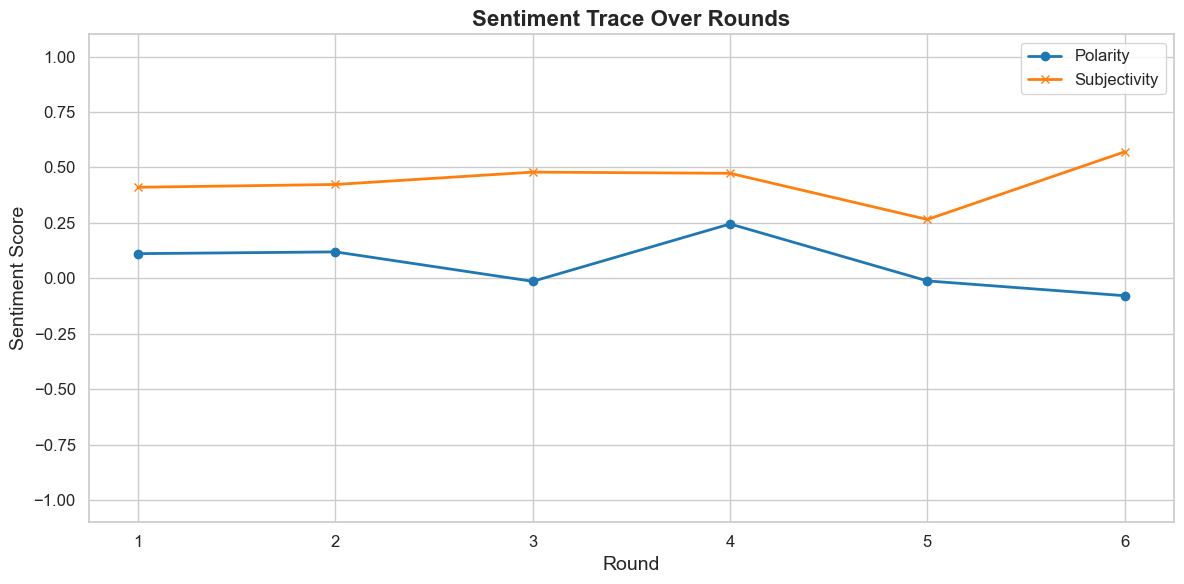

In [36]:
plot_sentiment_trace("results/20250521_212930/google_gemma-3-27b-it_free_sentiment.json")

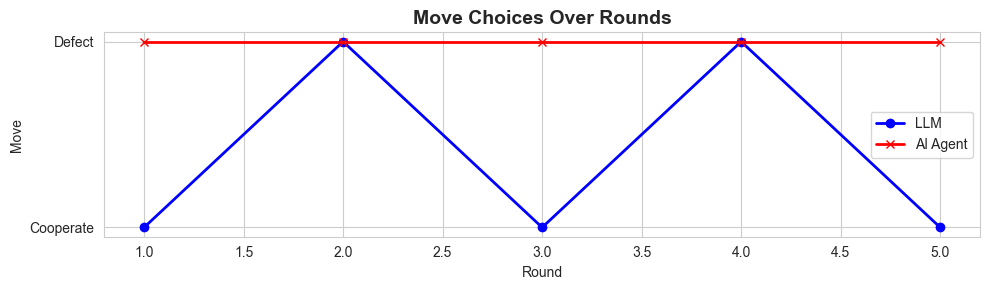

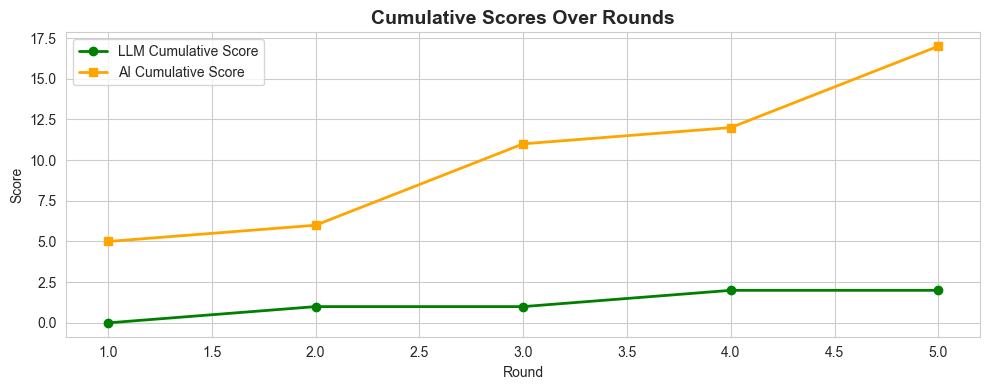

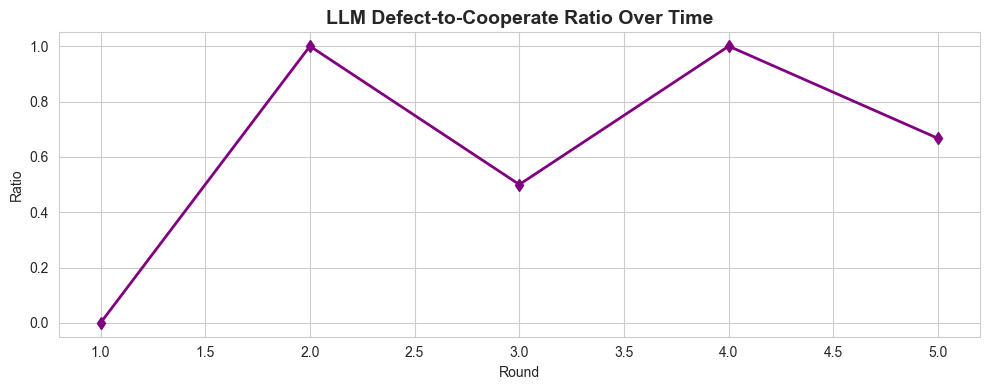

In [34]:
plot_game_summary("results/20250521_212930/final_game_state_.json")

In [16]:
import requests
import json

API_KEY = getenv("OPENAI_API_KEY")
response = requests.get(
  url="https://openrouter.ai/api/v1/auth/key",
  headers={
    "Authorization": f"Bearer {API_KEY}"
  }
)

print(json.dumps(response.json(), indent=2))

{
  "data": {
    "label": "sk-or-v1-098...a2a",
    "limit": 15,
    "usage": 0,
    "is_provisioning_key": false,
    "limit_remaining": 15,
    "is_free_tier": false,
    "rate_limit": {
      "requests": 160,
      "interval": "10s"
    }
  }
}
